# Environment setup

In [1]:
# Install necessary libraries
!pip install -q openai langchain langchain-openai langchain-community openai-whisper sentence-transformers pdf2image
!apt-get install poppler-utils
!pip install --upgrade Pillow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.6).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [2]:
%cd /content/drive/MyDrive/CAPSTONE PROJECT - MultiModal Starbucks Finance

/content/drive/MyDrive/CAPSTONE PROJECT - MultiModal Starbucks Finance


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from google.colab import userdata
api_key = userdata.get('genai_course')

In [5]:
# Import libraries
from langchain_openai import ChatOpenAI
from openai import OpenAI
from IPython.display import display, Markdown
from sentence_transformers import SentenceTransformer
import whisper
import pandas as pd
import base64
from pdf2image import convert_from_path
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import os
import torch

# Audio Transcription

In [6]:
# Check if GPU is avalaible
device  = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {device}")

using device: cuda


In [7]:
whisper.available_models()

['tiny.en',
 'tiny',
 'base.en',
 'base',
 'small.en',
 'small',
 'medium.en',
 'medium',
 'large-v1',
 'large-v2',
 'large-v3',
 'large',
 'large-v3-turbo',
 'turbo']

In [8]:
# Transcribe the audio using wHisper
model = whisper.load_model("base", device=device)
input_file = "starbucks-q3.mp3"
result = model.transcribe(input_file)
transcription_text = result['text']

/usr/local/lib/python3.11/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)


In [9]:
# Check the transcription output
print("Transcription Output:")
print(transcription_text)

Transcription Output:
 2024. And with that, I'll now tell Nicole over to Luxembourg. Thank you Tiffany and thank you for joining us this afternoon. Let me start by laying out our results for the squatter. Our Q3 total company revenue was $9.1 billion up 1% year over year and 6% over Q2. Our global comparable store sales declined 3% year over year driven by a negative 2% Comcro in North America and a negative 14% Comcro in China and partially offset by strong performance in Japan. Our global operating margins contracted by 70 basis points to 16.7% and overall earnings per share for the quarter was 93 cents. Our total company results were in line with guidance but international performance particularly in China was challenged. We are not satisfied with the results but our actions are making an impact. Leading business and operational indicators are trending in the right direction ahead of our financial results and our runway for improvement is long. We see green shoots in our US business

In [10]:
# Save the transcription to a text file
os.makedirs("transcript", exist_ok=True)
with open("transcript/transcription.txt", "w") as f:
    f.write(transcription_text)

# Embed Transcription

In [11]:
# Load transcription text and split into chunks of 100 characters
with open("transcript/transcription.txt", "r") as f:
     text = f.read()

chunk_size = 250
audio_chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

# Summary of the chuncks
print("Number of chunks: ", len(audio_chunks))
print("First chunk: ", audio_chunks[:3])

Number of chunks:  57
First chunk:  [" 2024. And with that, I'll now tell Nicole over to Luxembourg. Thank you Tiffany and thank you for joining us this afternoon. Let me start by laying out our results for the squatter. Our Q3 total company revenue was $9.1 billion up 1% year over year ", 'and 6% over Q2. Our global comparable store sales declined 3% year over year driven by a negative 2% Comcro in North America and a negative 14% Comcro in China and partially offset by strong performance in Japan. Our global operating margins contract', 'ed by 70 basis points to 16.7% and overall earnings per share for the quarter was 93 cents. Our total company results were in line with guidance but international performance particularly in China was challenged. We are not satisfied with the results']


In [12]:
# Load the CLIP model and embed the chunks
clip_model = SentenceTransformer('clip-ViT-B-32', device= device)
audio_embeddings = clip_model.encode(audio_chunks)


# Check shape of embeddings
print(f"\nAudio Embeddings Shape: {audio_embeddings.shape}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Audio Embeddings Shape: (57, 512)


# Convert PDF to Images

In [13]:
# Convert each page of a PDF into images
pdf_path = '3Q24-Earnings-Release.pdf'
output_folder = 'images'
os.makedirs(output_folder, exist_ok=True)

In [14]:
images = convert_from_path(pdf_path)
image_paths = []

for i, image in enumerate(images):
    image_path = f'images/page_{i + 1}.png'
    image.save(image_path, 'PNG')
    image_paths.append(image_path)

print(f"PDF pages have been converted to images and saved in '{output_folder}'")
print(f"\nNumber of Images: {len(image_paths)}")
print(f"Image Paths: {image_paths[:3]}")  # Print first 3 image paths to check

PDF pages have been converted to images and saved in 'images'

Number of Images: 17
Image Paths: ['images/page_1.png', 'images/page_2.png', 'images/page_3.png']


# Embed Images

In [15]:
# Load the CLIP model for embedding images
image_model = SentenceTransformer('clip-ViT-B-32')
image_embeddings = []

for filename in os.listdir(output_folder):
    if filename.endswith('.png'):
        image_path = os.path.join(output_folder, filename)
        image = Image.open(image_path)
        embedding = image_model.encode(image)
        image_embeddings.append(embedding)

In [16]:
# Check image embeddings
print(f"\nNumber of Image Embeddings: {len(image_embeddings)}")
print(f"First Image Embedding Shape: {image_embeddings[0].shape}")


Number of Image Embeddings: 17
First Image Embedding Shape: (512,)


# Similarity Retrieval

In [17]:
# Define a query and embed it
query = "Why the company revenue is declining?"
query_embeddings = clip_model.encode(query)

In [18]:
# Print query embedding shape
print(f"\nQuery Embedding Shape: {query_embeddings.shape}")


Query Embedding Shape: (512,)


In [19]:
# Compute similarity with transcription embeddings
audio_similarities = cosine_similarity([query_embeddings], audio_embeddings)[0]
top_k_audio_indices = audio_similarities.argsort()[-20:][::-1]

In [20]:
# Print top 5 similar audio chunks
print("\nTop 5 Most Similar Audio Chunks (Indices):", top_k_audio_indices[:5])
print("Top 5 Audio Similarities:", audio_similarities[top_k_audio_indices[:5]])


Top 5 Most Similar Audio Chunks (Indices): [46 37 27 48  3]
Top 5 Audio Similarities: [0.8655904  0.8653591  0.8647377  0.86363703 0.8597297 ]


In [21]:
# Compute cosine similarity between the query embedding and each image embedding
image_similarities = [(idx, cosine_similarity(query_embeddings.reshape(1, -1), embed.reshape(1, -1))[0][0])
                      for idx, embed in enumerate(image_embeddings)]

In [22]:
# Sort by similarity and get top 2 most similar images
top_2_images = sorted(image_similarities, key=lambda x: x[1], reverse=True)[:2]

In [23]:
# Print top 2 similar images
print("\nTop 2 Most Similar Images (Indices):", [i[0] for i in top_2_images])
print("Top 2 Image Similarities:", [i[1] for i in top_2_images])


Top 2 Most Similar Images (Indices): [9, 8]
Top 2 Image Similarities: [0.27711537, 0.2769457]


# Prepare Context

In [24]:
# Combine the top transcription chunks into a single text context
text_context = ' '.join([audio_chunks[idx] for idx in top_k_audio_indices])

In [25]:
# Print combined text context
print(f"\nText Context (First 300 characters): {text_context[:300]}...")


Text Context (First 300 characters):  to remain engaged across channels and drive greater lifetime value. In summary, our plans are beginning to work. We've recovering our brand from its perceptions. We're rebuilding the operational foundation of our stores and supply chain. We're reduc  frequency of their visits. We're focused on the ...


In [26]:
# Convert the top 2 images to base64 format
base64frames = []
for idx, _ in top_2_images:
    image_path = image_paths[idx]
    with open(image_path, "rb") as img_file:
        base64frames.append(base64.b64encode(img_file.read()).decode('utf-8'))

In [27]:
# Print base64 encoding of first image
print(f"\nBase64 of First Image (First 100 characters): {base64frames[0][:100]}...")


Base64 of First Image (First 100 characters): iVBORw0KGgoAAAANSUhEUgAABqQAAAiYCAIAAAA+NVHkAAEAAElEQVR4nOzddVhU2RsH8Hdm6G5pFLBQAUFBscVAxe7ubl3bVdda...


# Generate Answer

In [28]:
# Define a system prompt for OpenAI API
client = OpenAI(api_key = api_key)
system_prompt = """
You are a financial adviser. Answer based on the provided financial data.
You explain in clear terms with the data avalible only
"""

In [29]:
# Prepare the list of images
image_data_list = [{"type": "image_url",
                    "image_url": {"url": f'data:image/png;base64,{img}', "detail": "high"}} for img in base64frames]

# Prepare message content with text and images
user_message_content = [
    {"type": "text", "text": text_context},
    *image_data_list  # Unpack the image_data_list to include each image as a separate item
]

[{'type': 'text',
  'text': " to remain engaged across channels and drive greater lifetime value. In summary, our plans are beginning to work. We've recovering our brand from its perceptions. We're rebuilding the operational foundation of our stores and supply chain. We're reduc  frequency of their visits. We're focused on the continued growth of the program because the average active member spends materially more annually and drives a high- lifetime value for the business than a non-member. Research also tells us that the m both our strategic sourcing and revenue management capabilities. Our second priority is to drive demand through relevant product innovation with coffee and our core. We've seen meaningful improvement here as well. This quarter we drove traffic into o mprovements we're making. And I'm reassured by the impact our work is expected to deliver in FY 2025 and beyond. Looking outside the US, we continue to see weakness in parts of our international business and strength i
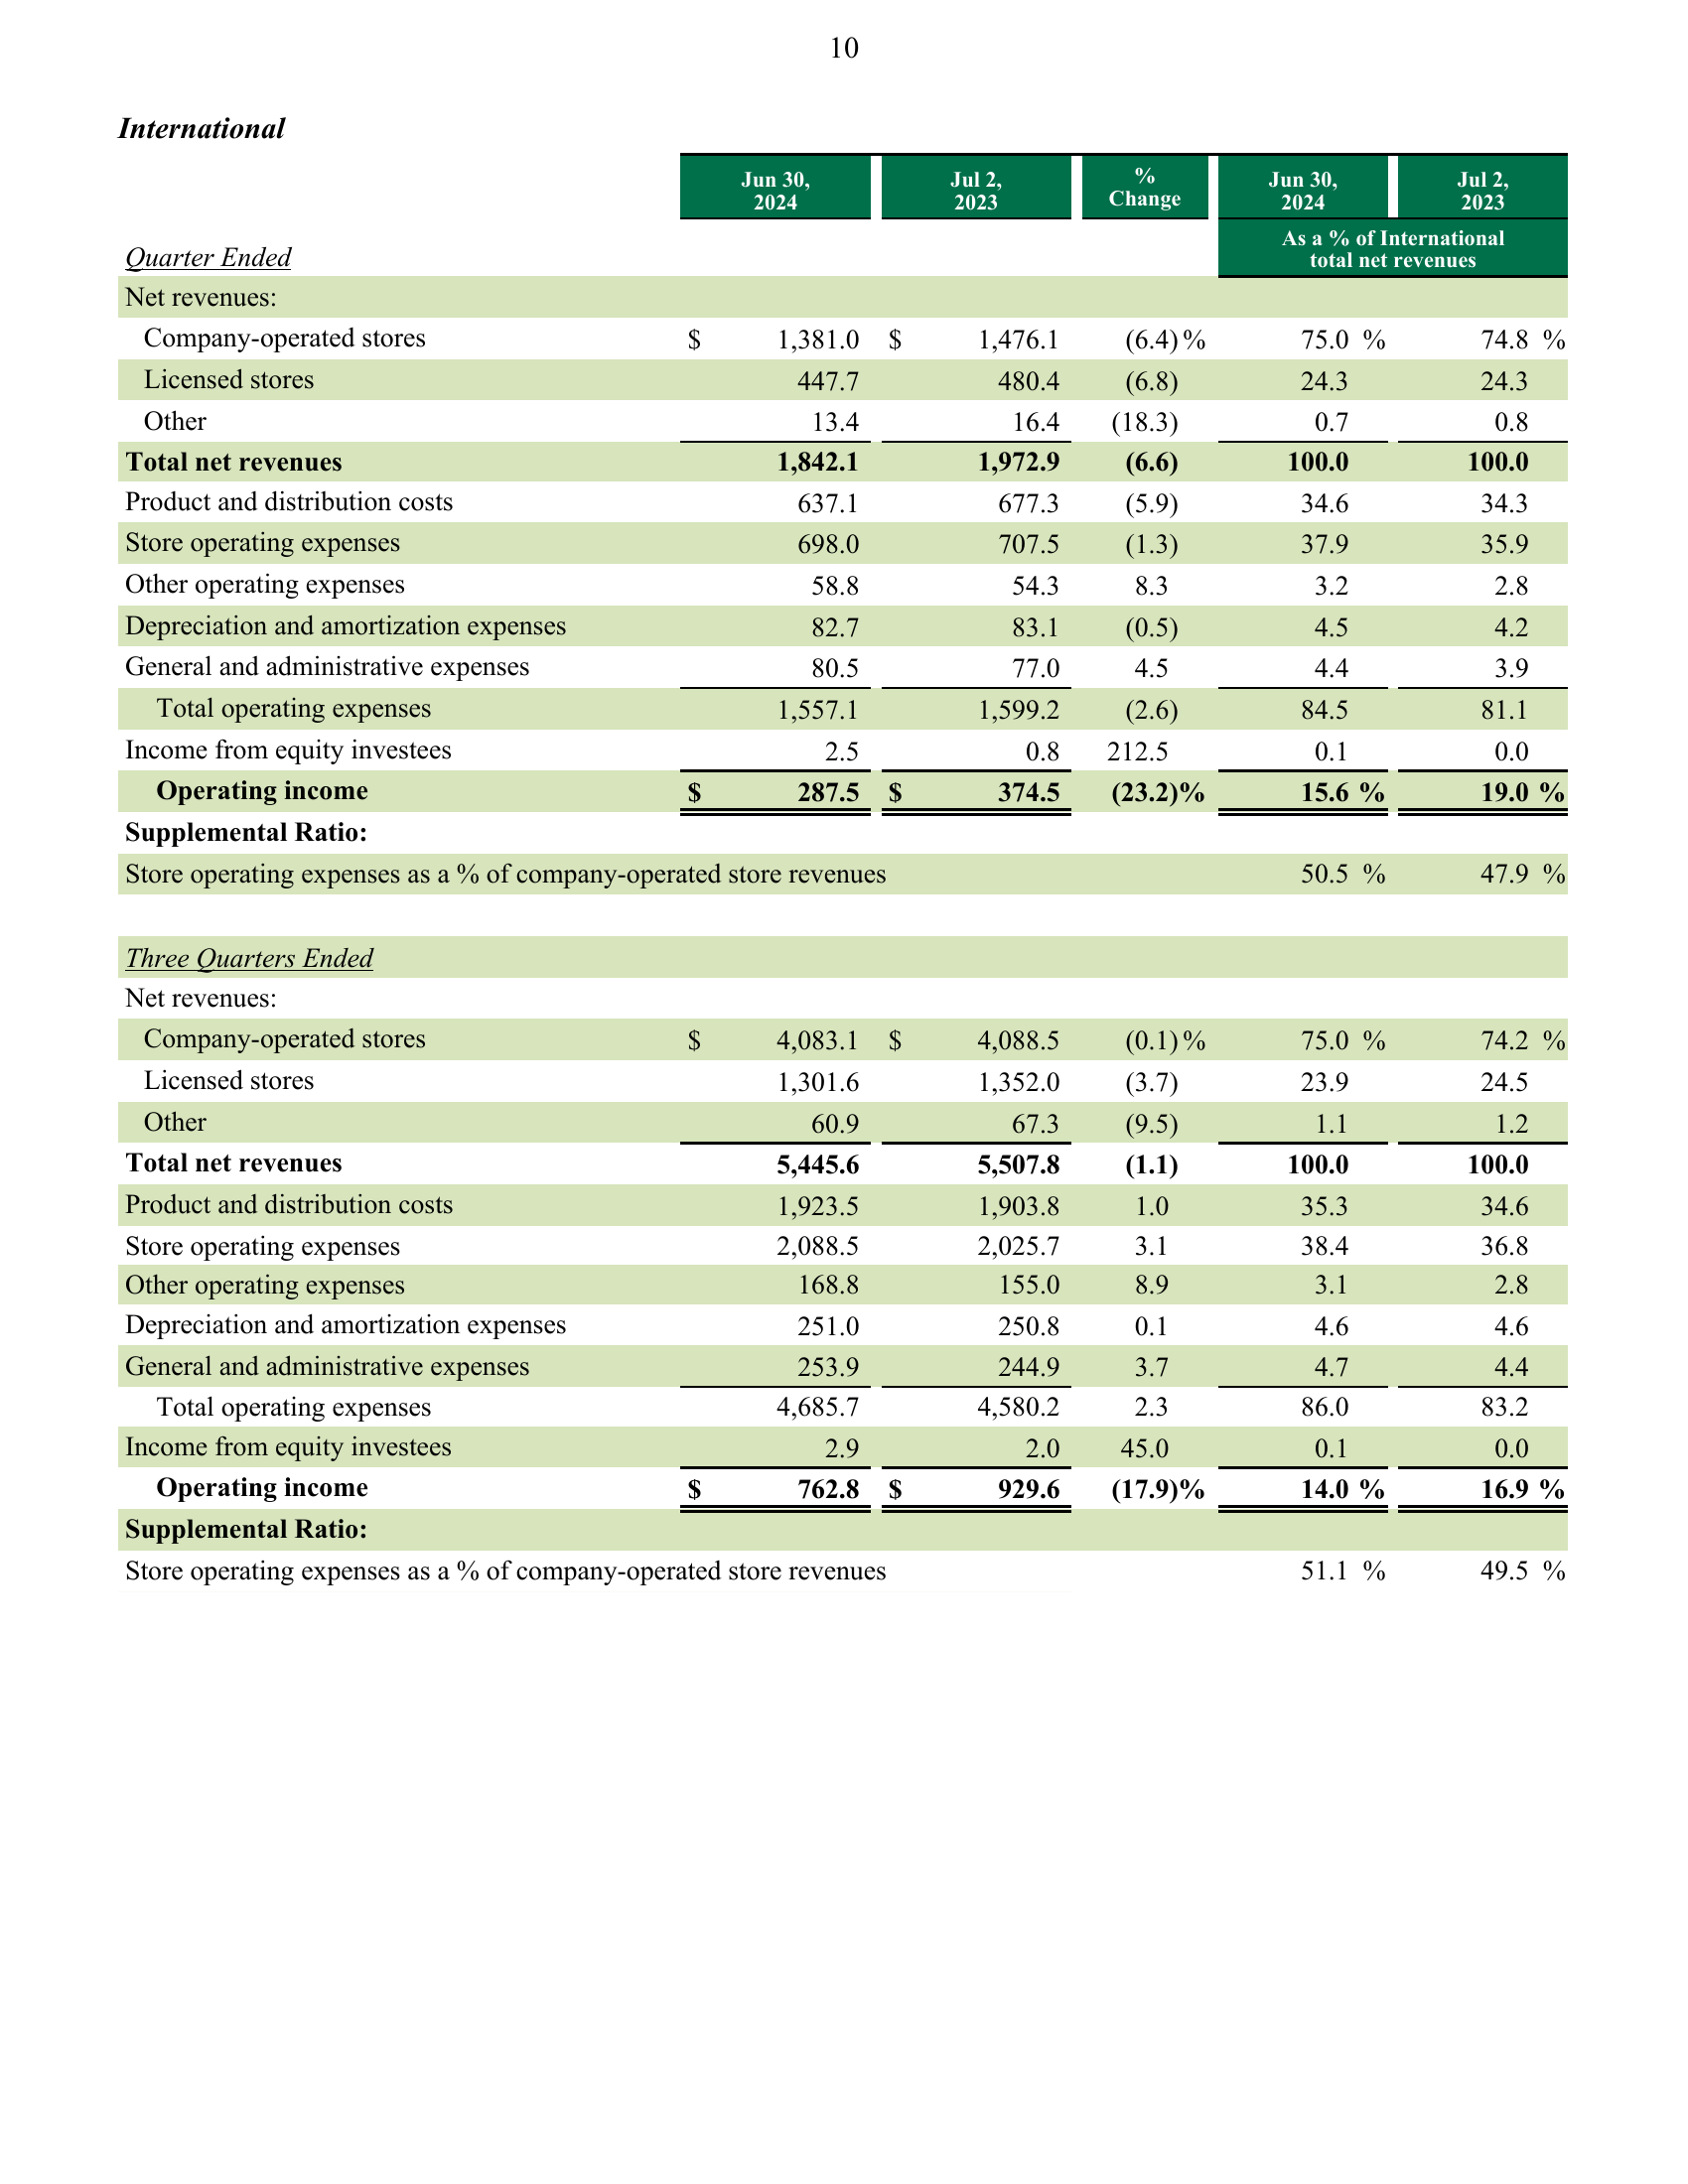
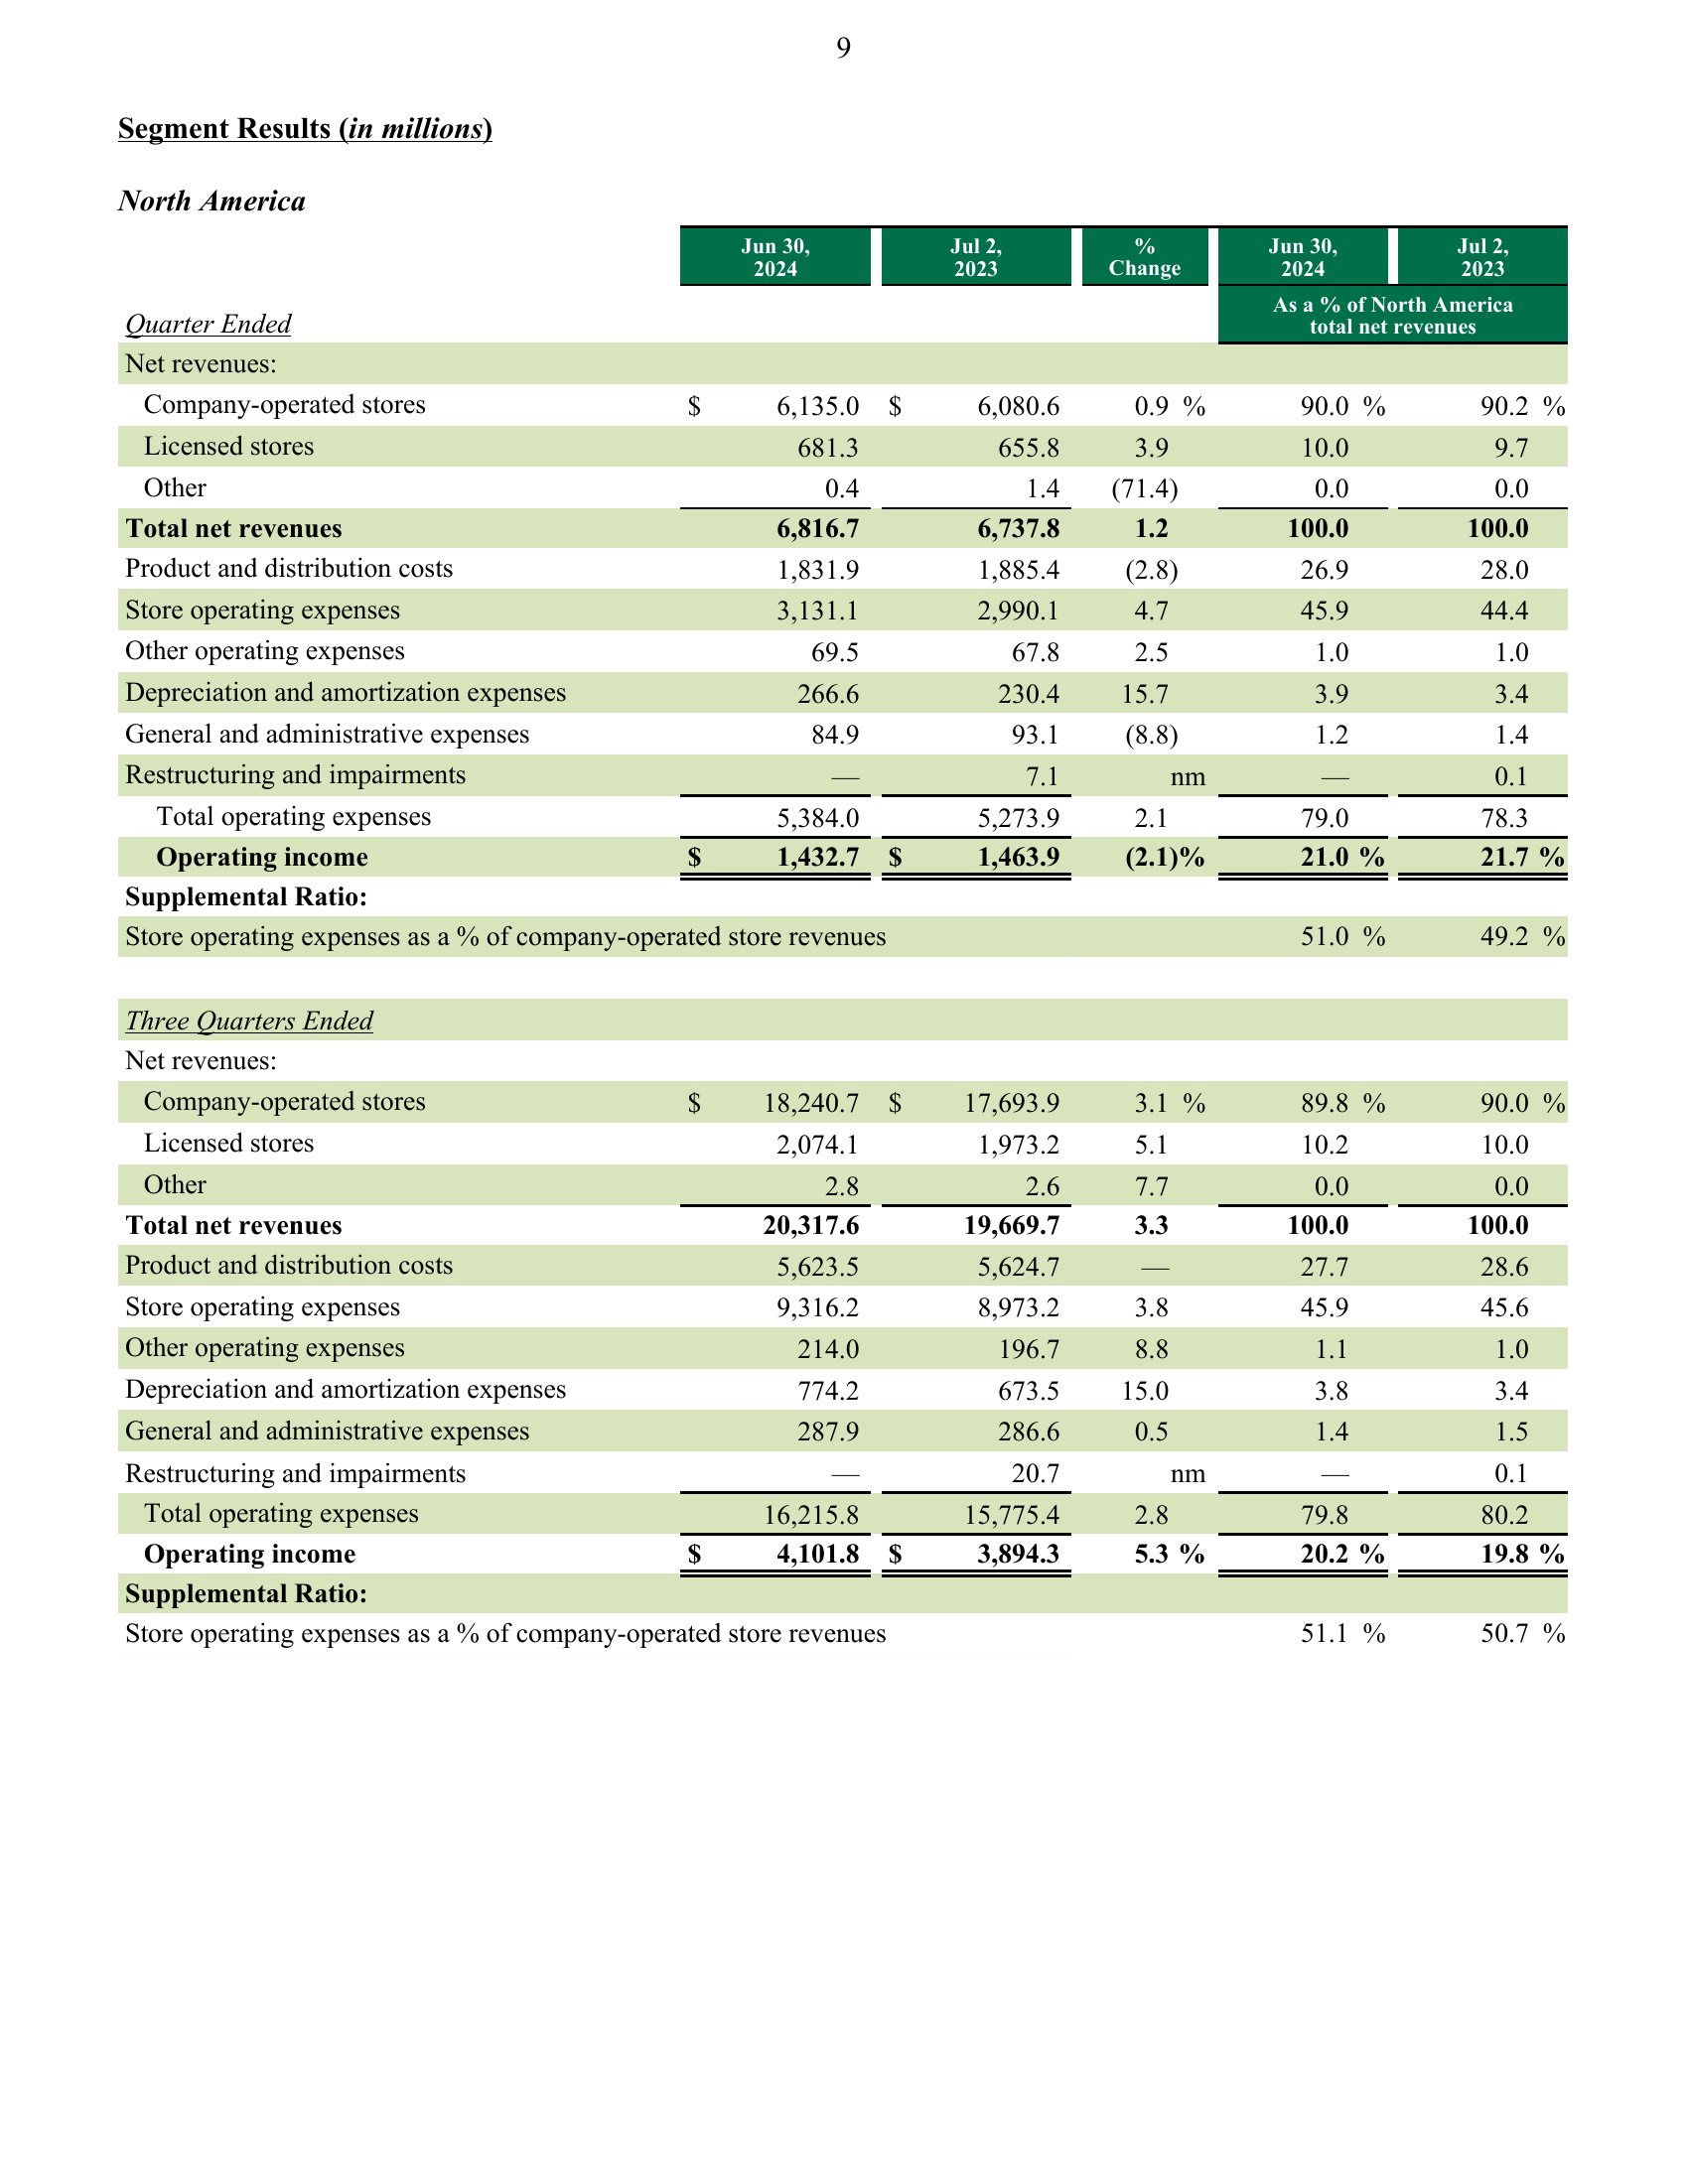

In [30]:
user_message_content

In [31]:
# Generate response from OpenAI
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_message_content}
    ],
    temperature=0.2
)

In [32]:
# Display the generated response
display(Markdown(response.choices[0].message.content))

Based on the provided financial data, here's a summary of key insights:

### International Segment (Quarter Ended)
- **Net Revenues**: Decreased by 6.6% from $1,972.9 million to $1,842.1 million.
- **Company-operated Stores**: Revenue declined by 6.4%.
- **Store Operating Expenses**: Increased by 1.3%, indicating rising operational costs.
- **Operating Income**: Dropped significantly by 23.2% to $287.5 million.
- **Store Operating Expenses as % of Revenues**: Increased from 47.9% to 50.5%.

### North America Segment (Quarter Ended)
- **Net Revenues**: Increased by 1.2% from $6,737.8 million to $6,816.7 million.
- **Company-operated Stores**: Revenue grew by 0.9%.
- **Store Operating Expenses**: Increased by 2.5%, reflecting higher costs.
- **Operating Income**: Slightly increased by 2.1% to $1,432.7 million.
- **Store Operating Expenses as % of Revenues**: Increased from 49.2% to 51.0%.

### Overall Company Performance (Three Quarters Ended)
- **Total Net Revenues**: Increased by 2.8% to $20,317.6 million.
- **Operating Income**: Increased by 5.3% to $4,101.8 million.
- **Store Operating Expenses as % of Revenues**: Increased from 50.7% to 51.1%.

### Key Takeaways
- **Challenges in International Markets**: Notable weakness in regions like China, with increased competition and cautious consumer spending impacting revenues.
- **Strength in North America**: Despite rising costs, North America shows growth in revenues and operating income, indicating resilience.
- **Operational Efficiency**: There are ongoing efforts to improve operational efficiency, particularly in supply chain management and store performance metrics.

### Strategic Focus
- Continued emphasis on product innovation and customer engagement through loyalty programs is crucial for driving traffic and increasing lifetime value.
- Addressing operational challenges and enhancing the customer experience will be vital for sustaining growth in both domestic and international markets. 

This analysis highlights the need for strategic adjustments in response to market dynamics while leveraging strengths in core areas.